## Vanilla Multilabel classification model with TensorFlow

Details of this vanilla 'not-deep' model below

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.datasets import fetch_mldata

import matplotlib.pyplot as plt
%matplotlib inline

## Load Data

### Yeast

Yeast is a dataset for multi-label classification. 

It doesn't really matter for this task but it is a 'Predicting the Cellular Localization Sites of Proteins' dataset.

<table>
  <tr>
    <th>Features</th>
    <th>Labels</th>
  </tr>
  <tr>
    <td>103 numeric features</td>
    <td>14 multi labels</td>
  </tr>
  <tr>
</table>

In summary, with 103 cell features we have to predict the **protein localization site** inside of the cell. Some of that 14 possible values are: *nuclear*, *mitochondrial*, *vacuolar*... And, of course, there could be proteins in **several sites** of the same cell, because of that, is a multi-label dataset.

Dataset extracted from sklearn repositories.

Same (or similar) dataset also available on <a href="https://archive.ics.uci.edu/ml/datasets/Yeast">UCI - Machine Learning Repository</a>

In [2]:
yeast_dataset = fetch_mldata("yeast")

X = yeast_dataset.data
Y = yeast_dataset.target.toarray().astype(np.int).T

#Tiny function to get a random example for "evaluación no honesta"
def get_random_example_with_labels():
    rand_idx = np.random.randint(0,X.shape[0])
    return X[rand_idx:rand_idx+1,:],Y[rand_idx:rand_idx+1,:]

print('Overview:')
print('Features shape: ',X.shape)
print('Labels shape: ',Y.shape)

print('\nSample first observation:')
print('Features:\n %s' % X[0])
print('(Multi)Labels:\n %s' % Y[0])

Overview:
Features shape:  (2417, 103)
Labels shape:  (2417, 14)

Sample first observation:
Features:
 [ 0.0937    0.139771  0.062774  0.007698  0.083873 -0.119156  0.073305
  0.00551   0.027523  0.043477 -0.024946  0.061221  0.147377  0.082805
 -0.011043 -0.001974 -0.147627  0.123673  0.005631  0.030659  0.005683
  0.053414  0.069935  0.033555  0.105394 -0.013519  0.119103 -0.057485
 -0.02878   0.144546  0.101353  0.024763  0.011344  0.057414 -0.104664
 -0.01905  -0.113221 -0.209969 -0.107153  0.417066  0.047501 -0.198307
 -0.235089  0.138778 -0.224982 -0.154866 -0.320172 -0.027004  0.057681
  0.052144 -0.033012 -0.013225  0.03099   0.017338 -0.108284 -0.034352
  0.156367  0.138615 -0.068087  0.061809  0.027936  0.068643  0.05846
 -0.113733 -0.05492  -0.103299  0.016608 -0.066824  0.032705 -0.064818
  0.009862 -0.088176 -0.018139 -0.034046 -0.098636 -0.174344 -0.070711
 -0.081028  0.105889 -0.004947 -0.039124 -0.007124  0.017693 -0.068304
 -0.021874 -0.011525 -0.029076  0.026808 -0.04

## Hyperparams

In [3]:
num_instances = X.shape[0]

num_features = X.shape[1]

num_classes = 14

learning_rate = 0.00001

batch_size = 16

num_batches = num_instances//batch_size

## Model

### Overview
Despite a multi-class model, to make it multi-label, we have to modify the **last layer** and the **evaluation** in order to be able to train it **with regard to multiple possible correct classes** for each observation.

### Last layer

In a multi-class model it's common to see a **softmax layer** as last layer (softmax squashes probs between [0,1]) and then computes the **loss** with **softmax cross entropy** that, according to TF doc: *Measures the probability error in discrete classification tasks in which the classes are mutually exclusive*

In a **multi-label** model instead, we could use a **sigmoid layer** as last layer and then compute the **loss** with **sigmoid cross entropy** that, according to TF doc: *Measures the probability error in discrete classification tasks in which each class is independent and not mutually exclusive. For instance, one could perform multilabel classification where a picture can contain both an elephant and a dog at the same time.*

### Evaluation

Given that each observation now is like:

Features | Label1 | Label2 | Label 3

Observ0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;0&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;1  

Usually, *argmax* function will be used, to adapt this to the multi-label case, we simply use *round*, that will turn the probabilities into 0 and 1. Then compare with the true label vector and, maybe, count the true labels, count the positive true labels etc.

Sigmoid out: [0.21, 0.89, 0.45] => Apply *round*<br>
Prediction: [0,1,0]<br>
True labels: [0,1,1]<br>
Number correct: 2 (First and second label)<br>


*Importante note: The final prediction depends on the round behaviour. round function default behaviour is just round to the nearest integer, but it could be used any other method, like set a threshold. This could be understood as a new hyperparameter for the model, and this is not a good thing* 

### Summary

A **single-layer** 'not deep' model with **Sigmoid function** and **Sigmoid Cross Entropy** as **loss** function. Also **Gradient Descent** will be used as **optimizer**, for the sake of simplicity.

### Future Work

Well, everything, this is just a test

1. Make it deep
2. Different type of activation functions in hidden layers (but always sigmoid as last!)
3. Dropout layers
4. Tunning the loss function
5. Different optimizers
- ...
<br>

Almost everything that could be done on any Deep Learning model




### Placeholders

In [4]:
data_ph = tf.placeholder(dtype=tf.float32,shape=[None,num_features],name='data') #[batch_size x num_features]
label_ph = tf.placeholder(dtype=tf.float32,shape=[None,num_classes],name='labels') #[batch_size x num_classes]

### Core

Weight and bias and the fully 'Sigmoid' connected layer

In [24]:
W = tf.Variable(dtype=tf.float32,initial_value=tf.truncated_normal(shape=[num_features,num_classes]))
b = tf.Variable(dtype=tf.float32,initial_value=tf.constant(0.1,shape=[num_classes]))

fc_sig = tf.nn.sigmoid(tf.matmul(data_ph,W) + b)

### Evaluation metrics

Multi-label ready

In [6]:
pred = tf.round(fc_sig) #Almost a hyperparam...

#The list containin the raw predictions. I.e: [[False,False,True,...,True]]
#False : Not well predicted
#True: Well predicted
correct_prediction_raw = tf.equal(pred, label_ph)

#Count non-zero to count 'True', in other words, correct predicted labels
num_correct_prediction = tf.count_nonzero(tf.equal(pred, label_ph)) 

#Simple acc
basic_acc = tf.divide(num_correct_prediction,num_classes)

### Loss functions & Optimizer

In [7]:
loss = tf.nn.sigmoid_cross_entropy_with_logits(labels = label_ph, logits=fc_sig)
optimizer = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

## Test

Some testing functions

In [8]:
def acc_test_n_observation(session,n=100):
    '''
    Returns the average accuracy on n (default 100) train observations
    '''
    acc_list = []
    for _ in range(n):
        test_x,test_y = get_random_example_with_labels()            
        _acc = sess.run(basic_acc,feed_dict={data_ph : test_x, label_ph : test_y})
        acc_list.append(_acc)
        
    return np.average(acc_list)

## Train

In [20]:
num_epochs = 1000

display_freq = num_epochs//10

loss_list_av = []
loss_list_aux = []
loss_list_batches = []

acc_list = []

with tf.Session() as sess:
    tf.global_variables_initializer().run()
    
    for epoch in range(num_epochs):
        
        for batch_idx in range(num_batches):  
            offset = (batch_idx * batch_size) % (X.shape[0] - batch_size)
            
            batchX = X[offset:(offset + batch_size), :]
            batchY = Y[offset:(offset + batch_size), :]
            
            feed = {data_ph : batchX, label_ph : batchY}
            
            _, _loss = sess.run([optimizer,loss],feed_dict = feed)
            loss_list_aux.append(_loss)
        
        loss_list_batches.append(np.average(loss_list_aux[-num_batches:len(loss_list_aux)]))
                        
        if(epoch % display_freq == 0):
            #Average loss 
            loss_av = np.average(loss_list_aux)
            loss_list_aux = []
            loss_list_av.append(loss_av)
            
            #Test on n predictions
            av_acc = acc_test_n_observation(sess,100)
            acc_list.append(av_acc)
            
            #Make a prediction
            test_obs,test_label = get_random_example_with_labels()
            feed = {data_ph : test_obs, label_ph : test_label}
            
            _pred,_num_corrrect,_acc = sess.run([pred,num_correct_prediction,basic_acc],feed_dict=feed)
            
            if(len(loss_list_av) > 1):
                deltaLoss = loss_list_av[-2] - loss_av
            else: 
                deltaLoss = 0
            print('At epoch: %d - Av.Loss: %.3f - Delta: %.6f' %(epoch,loss_av,deltaLoss))
            print('Random prediction:')
            print('Predicted labels: %s\nReal labels:      %s' % (np.array(_pred,dtype=int),test_label))
            print('Correct labels:   %d' % _num_corrrect)
            print('Acc:              %.3f' % _acc)
            print()

At epoch: 0 - Av.Loss: 0.834 - Delta: 0.000000
Random prediction:
Predicted labels: [[1 0 1 1 0 0 1 1 1 1 1 0 1 1]]
Real labels:      [[0 0 0 1 1 0 0 0 0 0 0 0 0 0]]
Correct labels:   4
Acc:              0.286

At epoch: 100 - Av.Loss: 0.825 - Delta: 0.008620
Random prediction:
Predicted labels: [[0 0 0 1 0 0 0 0 1 0 1 1 1 1]]
Real labels:      [[1 1 0 0 0 0 0 0 0 0 0 0 0 0]]
Correct labels:   6
Acc:              0.429

At epoch: 200 - Av.Loss: 0.809 - Delta: 0.016454
Random prediction:
Predicted labels: [[1 0 0 0 0 0 1 1 1 0 0 1 1 0]]
Real labels:      [[0 0 0 1 1 0 0 0 0 0 0 1 1 0]]
Correct labels:   8
Acc:              0.571

At epoch: 300 - Av.Loss: 0.793 - Delta: 0.015145
Random prediction:
Predicted labels: [[0 0 0 0 0 0 0 0 0 0 0 0 1 0]]
Real labels:      [[0 1 1 0 0 0 0 0 0 0 0 1 1 0]]
Correct labels:   11
Acc:              0.786

At epoch: 400 - Av.Loss: 0.780 - Delta: 0.013520
Random prediction:
Predicted labels: [[1 1 1 0 1 1 0 0 0 0 0 1 1 0]]
Real labels:      [[1 1 1 1 0 0

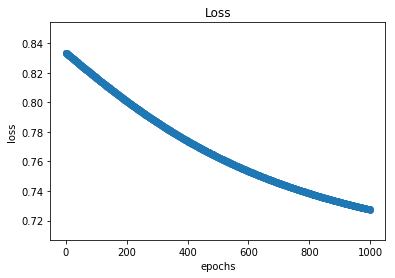

In [21]:
plt.title('Loss')
plt.scatter(x=np.arange(0,len(loss_list_batches)),y=loss_list_batches)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

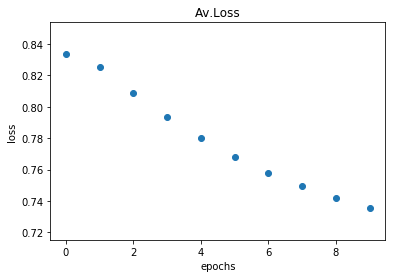

In [22]:
plt.title('Av.Loss')
plt.scatter(x=np.arange(0,len(loss_list_av)),y=loss_list_av)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show();

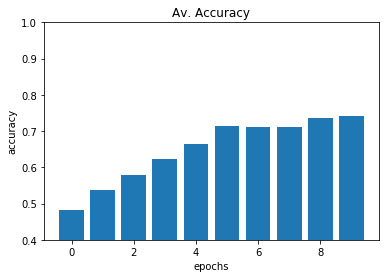

In [23]:
plt.title('Av. Accuracy')
plt.bar(left=np.arange(0,len(acc_list)),height=acc_list)
plt.ylim(0.4,1)
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show();